# Building Decision Models from Vinnie 0.3 Score Outputs  

Vinnie 0.3 scores represent the likelihood of a particular label applying to an image. 
The models below use the scores to assess whether a particular image contains a person, whether a person is wearing a hardhat, and whether a person is wearing a safety vest or safety colors. 
The three output categories are represented as has_people, has_hardhat, and has_safety, respectively. 

In [1]:
import csv
import numpy as np
from sklearn import neural_network 
from sklearn import metrics
from sklearn import preprocessing

## Generating a List of Score Categories 

In [2]:
# Generate a list of the column names to extract scores from
# Inputs a dictionary whose keys are the base category names, values are the different options for each category
# for each key, concatenates key + . + (each) value
# Outputs a list of strings, column names of all score columns
def gen_col_names(base_dict):
    score_categories = []
    for key in base_dict:
        options = base_dict[key]
        for opt in options:
            score_category = key + '.' + opt
            score_categories.append(score_category)
    return score_categories

In [3]:
# Dictionary whose keys are strings (base categories from Turk data)
# Values = list of possible selections for each category
# Order of the scores for training is based on the produced list of score categories (printed)
base_categories = {}
base_categories["clothing"] = ["hi_vis", "low_vis", "not_selected", "safety_vest"]
base_categories["gloves"] = ["bare_hands", "gloves", "just_hands", "no_hands", "not_selected"]
base_categories["head"] = ["any_hat", "hardhat", "hood", "no_hat", "not_selected"]
base_categories["kind_of_people"] = ["no_people", "non_worker", "worker"]
base_categories["location"] = ["indoor", "outdoor"]
base_categories["people_visibility"] = ["mixed_people", "no_people", "part_person", "whole_people", "whole_person"]
base_categories["footwear"] = ["boots", "just_feet", "no_feet", "not_selected", "shoes"]
base_categories["site_type"] = ["work_site", "not_work_site"]

score_categories = gen_col_names(base_categories)
for c in score_categories:
    print c

head.any_hat
head.hardhat
head.hood
head.no_hat
head.not_selected
site_type.work_site
site_type.not_work_site
kind_of_people.no_people
kind_of_people.non_worker
kind_of_people.worker
gloves.bare_hands
gloves.gloves
gloves.just_hands
gloves.no_hands
gloves.not_selected
location.indoor
location.outdoor
people_visibility.mixed_people
people_visibility.no_people
people_visibility.part_person
people_visibility.whole_people
people_visibility.whole_person
clothing.hi_vis
clothing.low_vis
clothing.not_selected
clothing.safety_vest
footwear.boots
footwear.just_feet
footwear.no_feet
footwear.not_selected
footwear.shoes


## Extracting Scores From Training and Testing Datasets

In [4]:
# Takes a string, filename of data file to open and read from and list of column names to index 
# Generates a 2d numpy array with shape (num_imgs, num_scores)
# Order of scores based on the input list of column names to index
def extract_data(data_file, score_cols):
    X_file = open(data_file, 'rb')
    X_csv = csv.DictReader(X_file)
    all_rows = list(X_csv)
    count = 0 
    for row in all_rows:
        count += 1
        row_scores = []
        for score_col in score_cols:
            score = float(row[score_col])
            row_scores.append(score)
        row_data = np.array([row_scores])
        if all_rows.index(row) == 0:
            all_scores = np.array(row_data)
        else:
            all_scores = np.append(all_scores, row_data, axis = 0)
    X_file.close()
    return all_scores

In [5]:
X_tr = extract_data('train_scores_clean.csv', score_categories)
print X_tr.shape
X_t = extract_data('validation_scores_ordered.csv', score_categories)
print X_t.shape

(15767, 31)
(1699, 31)


## Extracting Target Output for Each Category 

In [6]:
# Inputs string, name of files with targets and list of classes
# Generates a dict, with each class name as a key, 1D numpy array as value 
# with shape (num_imgs,)
def extract_target(target_file, classes):
    targets = {}
    for cl in classes:
        targets[cl] = []
    
    tf = open(target_file, 'rb')
    tf_csv = csv.DictReader(tf)
    for row in tf_csv:
        for cl in classes:
            targets[cl].append(int(row[cl])) # From each row, save the value for column into list corresponding to column
    targets_arrays = {}
    for cl in classes:
        targets_arrays[cl] = np.array(targets[cl])
    tf.close()
    return targets_arrays

In [7]:
target_cols = ["has_people", "has_hardhat", "has_safety"]
all_y_train = extract_target('y_train.csv', target_cols)
all_y_test = extract_target('ao-validation-vinnie_rules.csv', target_cols)

# Building Multi-Layer Perceptron Models for Each Output Category

In [9]:
# Uses scaled data
# Returns an MLPClassifier object based on inputs and category name
def build_MLP(col, hidden_layer_sizes):
    mlp = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation = 'relu', learning_rate = 'invscaling', solver = 'adam')
    mlp.fit(X_tr, all_y_train[col])
    return mlp
# Returns Classifier score (mean accuracy) based on category name
def get_accuracy(clf, col):
    return clf.score(X_t, all_y_test[col])
# Returns Confusion Matrix for the classifier 
def get_cm(clf, col):
    y_pred = clf.predict(X_t)
    return metrics.confusion_matrix(all_y_test[col], y_pred)

#### Model Assessing Presence of Person

In [10]:
# has_people
# Data scaled; all features included
ppl_mlp = build_MLP("has_people", 80)
ppl_acc = get_accuracy(ppl_mlp, "has_people")
ppl_cm = get_cm(ppl_mlp, "has_people")
all_accuracies["has_people"] = ppl_acc

#### Model Assessing Safety Gear -- Hardhat

In [11]:
# has_hardhat
# Data scaled, all features included
hh_mlp = build_MLP("has_hardhat", 80)
hh_acc = get_accuracy(hh_mlp, "has_hardhat")
hh_cm = get_cm(hh_mlp, "has_hardhat")
all_accuracies["has_hardhat"] = hh_acc

#### Model Assessing Safety Gear -- Safety Clothing

In [12]:
# has_safety
# Data scaled, all features included
s_mlp = build_MLP("has_safety", 80)
s_acc = get_accuracy(s_mlp, "has_safety")
s_cm = get_cm(s_mlp, "has_safety")
all_accuracies["has_safety"] = s_acc

## Accuracy Summary for Each Output Category

In [13]:
from tabulate import tabulate 
print tabulate([["has_people", ppl_acc], ["has_hardhat", hh_acc], ["has_safety", s_acc]], ["assessment", "accuracy"])

assessment      accuracy
------------  ----------
has_people      0.866392
has_hardhat     0.85462
has_safety      0.848735


## Visualizing Model Outputs - Probability Outputs

Useful for setting threshold values to further train models. Adjusting threshold values also allows users to cater the model to their needs (ex: Having more false negatives). 

### Range of Probabilities (Predictions) for Presence of Person 

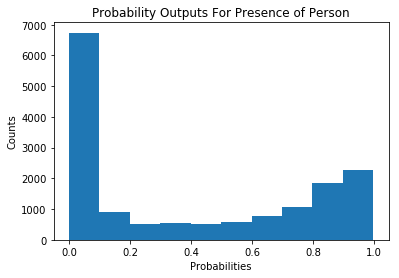

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt
ppl_prob = ppl_mlp.predict_proba(X_tr)[:,0]
fig, ax = plt.subplots()
plt.hist(ppl_prob)
ax.set_xlabel('Probabilities')
ax.set_ylabel('Counts')
ax.set_title('Probability Outputs For Presence of Person')

### Range of Probabilities (Predictions) for Wearing Hardhat 

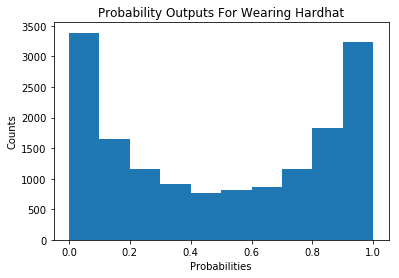

In [15]:
hh_prob = hh_mlp.predict_proba(X_tr)[:,0]
fig, ax = plt.subplots()
plt.hist(hh_prob)
ax.set_xlabel('Probabilities')
ax.set_ylabel('Counts')
ax.set_title('Probability Outputs For Wearing Hardhat')

### Range of Probabilities (Predictions) for Wearing Safety Colors or Safety Vest 

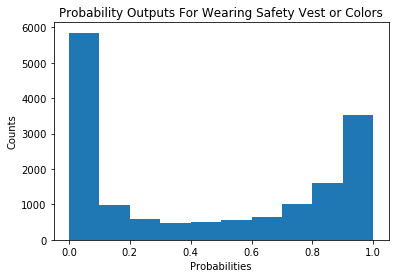

In [16]:
s_prob = s_mlp.predict_proba(X_tr)[:,0]
fig, ax = plt.subplots()
plt.hist(s_prob)
ax.set_xlabel('Probabilities')
ax.set_ylabel('Counts')
ax.set_title('Probability Outputs For Wearing Safety Vest or Colors')

## Confusion Matrices for Each Output Category

In [56]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, 3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print tabulate(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Confusion Matrix for Presence of Person

Confusion matrix, without normalization
---  ---
539   42
185  933
---  ---
Normalized confusion matrix
-----  -----
0.928  0.072
0.165  0.835
-----  -----


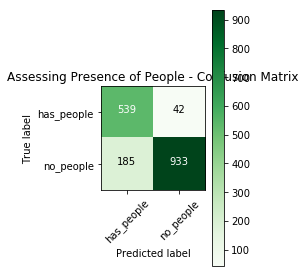

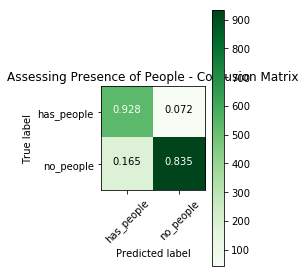

In [58]:
# has_people Confusion Matrix
class_names = ["has_people", "no_people"]
plot_title = "Assessing Presence of People - Confusion Matrix"
plt.figure()
plot_confusion_matrix(ppl_cm, classes = class_names, title = plot_title, cmap = plt.cm.Greens)
plt.figure()
plot_confusion_matrix(ppl_cm, normalize = True, classes = class_names, title = plot_title, cmap = plt.cm.Greens)


### Confusion Matrix for Wearing Hardhat

Confusion matrix, without normalization
---  ---
735  116
131  717
---  ---
Normalized confusion matrix
-----  -----
0.864  0.136
0.154  0.846
-----  -----


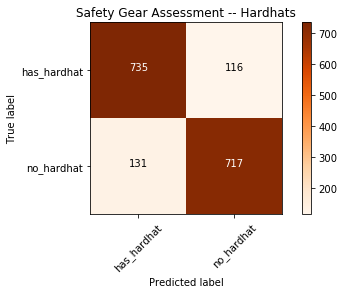

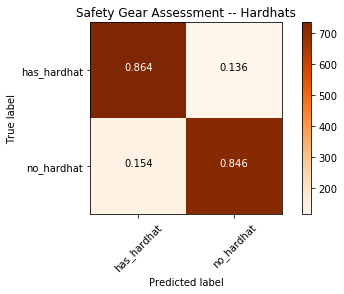

In [19]:
# has_people Confusion Matrix
class_names = ["has_hardhat", "no_hardhat"]
plot_title = "Safety Gear Assessment -- Hardhats"
plt.figure()
plot_confusion_matrix(hh_cm, classes = class_names, title = plot_title, cmap = plt.cm.Oranges)
plt.figure()
plot_confusion_matrix(hh_cm, normalize = True, classes = class_names, title = plot_title, cmap = plt.cm.Oranges)


### Confusion Matrix for Wearing Safety Colors or Safety Vest

Confusion matrix, without normalization
---  ---
706  157
100  736
---  ---
Normalized confusion matrix
-----  -----
0.818  0.182
0.12   0.88
-----  -----


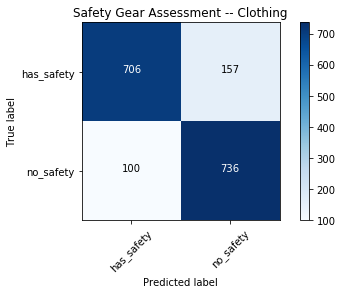

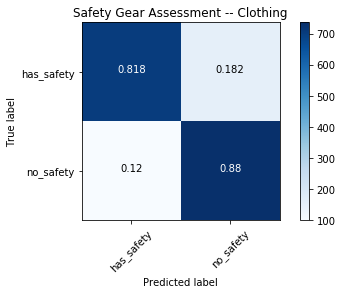

In [20]:
# has_people Confusion Matrix
class_names = ["has_safety", "no_safety"]
plot_title = "Safety Gear Assessment -- Clothing"
plt.figure()
plot_confusion_matrix(s_cm, classes = class_names, title = plot_title, cmap = plt.cm.Blues)
plt.figure()
plot_confusion_matrix(s_cm, normalize = True, classes = class_names, title = plot_title, cmap = plt.cm.Blues)


## Saving Model 

In [61]:
from sklearn.externals import joblib 
pfile = 'has_ppl_vin3.sav'
hfile = 'has_hh_vin3.sav'
sfile = 'has_safe_vin3.sav'
models = [ppl_mlp, hh_mlp, s_mlp]
files = [pfile, hfile, sfile]
for i in range(3):
    joblib.dump(models[i], files[i])

In [64]:
ppl = joblib.load(pfile)
ppl.score(X_t, all_y_test["has_people"])

0.86639199529134781